# Square Thermals
Assume:
* thermals are square with a certain width and a constant vertical velocity
* we know all the vertical velocities in some grid of size _grid_size_ (observations)

Then, find the position and width of these thermals.

 [-----------------100%-----------------] 20000 of 20000 complete in 56.8 sec

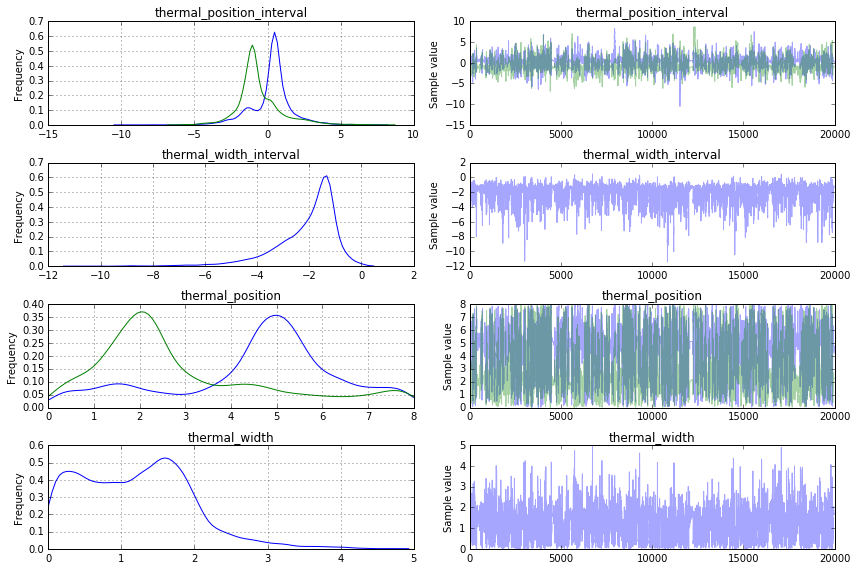

In [89]:
import numpy as np
import pymc3 as pm
import scipy as sp
import theano
import theano.tensor as t
import matplotlib.pyplot as plt

# Display plots in Jupyter
%matplotlib inline

# For reproducibility
np.random.seed(123)

data = [[0,0,0,0,0,0,0,0],
        [0,0,0,0,1,1,1,0],
        [0,0,0,0,1,1,1,0],
        [0,0,0,0,1,1,1,0],
        [0,1,1,0,0,0,0,0],
        [0,1,1,0,0,0,0,0],
        [0,0,0,0,0,0,0,0],
        [0,0,0,0,0,0,0,0]]
grid_size = len(data[0])

# From: http://stackoverflow.com/a/1401828
def dist(a, b):
    return np.linalg.norm(a-b)

with pm.Model() as model:
    # Priors
    thermal_position = pm.Uniform("thermal_position", 0, grid_size, shape=2)
    thermal_width = pm.Uniform("thermal_width", 0, grid_size)

    # Vertical velocity as function of the thermal's position and width
    @theano.compile.ops.as_op(itypes=[t.dvector, t.dscalar],otypes=[t.dmatrix])
    def velocityGrid(thermal_position, thermal_width):
        out = np.empty([grid_size,grid_size])
        for y in range(0, grid_size):
            for x in range(0, grid_size):
                if dist([x,y], thermal_position) <= thermal_width:
                    out[y,x] = 1
                else:
                    out[y,x] = 0
        return out

    vel = velocityGrid(thermal_position, thermal_width)
    thermal_vert_vel = pm.Normal('thermal_vert_vel', vel, observed=data)

    # Sample this to find the posterior, note Metropolis works with discrete
    step = pm.Metropolis()
    trace = pm.sample(20000, step=step, progressbar=True)
    pm.traceplot(trace);

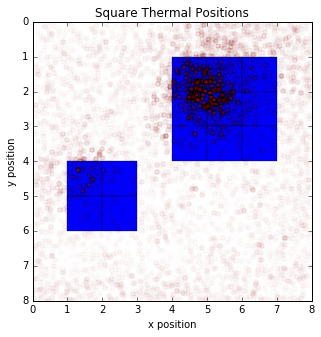

In [93]:
import matplotlib.cm as cm
from matplotlib.collections import PatchCollection
import matplotlib.patches as mpatches

# Visualization, from: http://stackoverflow.com/a/5741363
fig = plt.figure(figsize=(5,5))
ax = plt.gca()
ax.set_xlim([0,grid_size])
ax.set_ylim([0,grid_size])
ax.invert_yaxis() # +Y goes down
patches = []

for y in range(0, grid_size):
    for x in range(0, grid_size):
        if data[y][x] == 1:
            patches.append(mpatches.Rectangle((x,y),1,1,ec="none"))

collection = PatchCollection(patches, linewidth=0.25, edgecolors=(0,0,0,1))
ax.add_collection(collection)
plt.title('Square Thermal Positions')
plt.xlabel('x position')
plt.ylabel('y position')

# The learned values
plt.scatter(trace["thermal_position"][:,0], trace["thermal_position"][:,1], alpha=0.01, c="r")